In [2]:
from torchvision.models import resnet18, ResNet18_Weights
from matplotlib import pyplot as plt
import os
import gc
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as v2

from torch.utils.data import Dataset, DataLoader, random_split
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_f1_score
)
import seaborn as sns
import pandas as pd

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
!unzip archive.zip

In [21]:
# HYPER PARAMETER
BATCH_SIZE = 128
LEARNING_RATE = 1e-1
EPOCHS = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object


In [5]:
print(DEVICE)

cuda:0


In [22]:
train_dir = 'train'
test_dir = 'test'


transforms_train = v2.Compose([
    v2.Resize((48,48)),
    v2.RandomHorizontalFlip(), # data augmentation
    v2.RandomAutocontrast(p = 1.0),
    v2.ToTensor() # normalization
])

transforms_val = v2.Compose([
    v2.Resize((48,48)),
    v2.ToTensor()
])


train_ds = datasets.ImageFolder(train_dir, transforms_train)
valid_ds = datasets.ImageFolder(test_dir, transforms_val) # use test folder for validation

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_ds))
print('Validation dataset size:', len(valid_ds))

class_names = train_ds.classes
print('Class names:', class_names)



Train dataset size: 28709
Validation dataset size: 7178
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def view_image(tensor_image,axis):

  np_image = torch.squeeze(tensor_image.detach()).permute([1,2,0]).numpy()
  arr_ = np.squeeze(np_image) # remove batch
  axis.imshow(arr_)

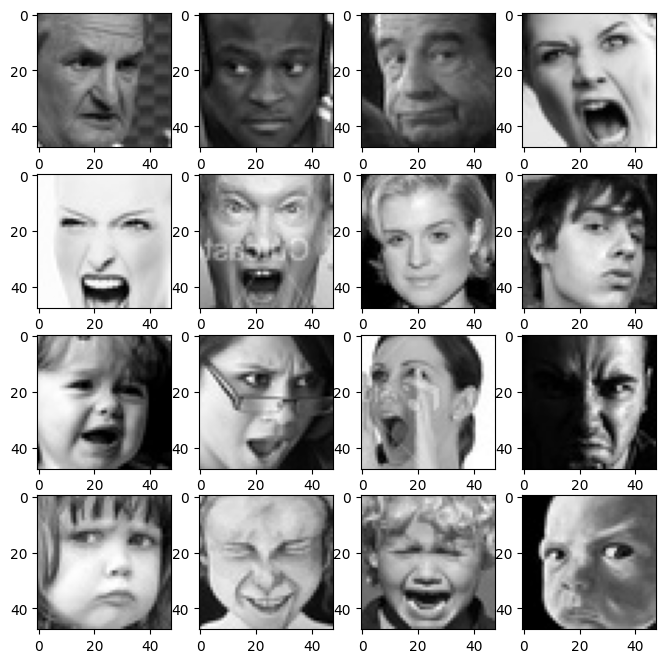

In [8]:
fig, ax = plt.subplots(4,4,figsize = (8,8))
cnt = 16
for i in range(0,4):
  for j in range(0,4):
    view_image(train_ds[cnt][0],ax[i][j])
    cnt = cnt + 1

# Model prepareation

In [32]:
model = resnet18()
model
# num_in_feature = model.fc.in_features
# num_out_feature = model.fc.out_features # not used just in case
# model.fc = nn.Linear(num_in_feature,len(class_names))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### fixing classification layer

In [33]:
old_in_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(old_in_features,512),
                                 nn.Linear(512,256),
                                 nn.Linear(256,len(class_names)))

### freezing layer

In [34]:
cnt = 0
freeze_threshold = 5
for child in model.children():
  # print(cnt)
  # print(child)
  # print('\n\n')

  if(cnt < freeze_threshold):
    for param in child.parameters():
      param.requires_grad = False
  else:
    for param in child.parameters():
      param.requires_grad = True

  cnt = cnt + 1

### test forwarding

In [35]:
model.train()
for i, batch in enumerate(train_dl):
  x, y = batch
  res = model(x)
  break


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [36]:
model.eval()
for i, batch in enumerate(train_dl):
  x, y = batch
  res = model(x)
  break

# setup training, testing and utility function

In [48]:
def multiclass_confusion_value(predict, true, num_class):
  # predict : shape = (batch)
  # true : shape = (batch)
  # num_class : int
  class_confusion_dict = {}

  for cidx in range(0,num_class):
    class_confusion_dict[cidx] = {'TP':0,'TN':0,'FP':0,'FN':0}

  for cidx in range(0,num_class):
    for idx in range(0,predict.shape[0]):
      if(predict[idx] == true[idx] and predict[idx] == cidx):
        class_confusion_dict[cidx]['TP'] = class_confusion_dict[cidx]['TP'] + 1
      elif(predict[idx] != true[idx] and predict[idx] == cidx):
        class_confusion_dict[cidx]['FP'] = class_confusion_dict[cidx]['FP'] + 1
      elif(predict[idx] == true[idx] and predict[idx] != cidx):
        class_confusion_dict[cidx]['FN'] = class_confusion_dict[cidx]['FN'] + 1
      else:
        class_confusion_dict[cidx]['TN'] = class_confusion_dict[cidx]['TN'] + 1
  return class_confusion_dict


def multiclass_f1_score_aggregation(confusion_values_dict,num_class):

  f1_list = []
  for cidx in range(0,num_class):
    TP = confusion_values_dict[cidx]['TP']
    FP = confusion_values_dict[cidx]['FP']
    FN = confusion_values_dict[cidx]['FN']
    f1_list.append(2 * TP/ (2 * TP + FP + FN))

    # return the micro average
  return np.array(f1_list).mean()



def train_one(device,dl,model,loss_fn,optim, epoch,loss_display_interval):
  model.train()
  total_loss = 0.0
  run_loss = 0.0
  num_batch = len(dl)
  for i, batch in enumerate(dl):
    # X is tensor in shape (batch, channel = 3, width, height)
    # y is a label tensor in shape (batch, 1)
    # loss function is cross-entrophy

    X, y = batch
    X, y = X.to(device), y.to(device)

    optim.zero_grad()
    pred = model(X)
    # pred is in shape (batch, len_class) aka one hot encoded

    loss = loss_fn(pred, y)
    loss.backward()
    optim.step()

    run_loss = run_loss + loss.item()/len(batch)

    if (i + 1) % loss_display_interval == 0:
      total_loss = total_loss + run_loss/loss_display_interval
      print(f'epoch = {epoch} : progress {i} / {num_batch} batches :  loss = {run_loss / 1000}')

def test(device,dl,model,loss_fn):
  global class_names
  num_class = len(class_names)
  model.eval()
  total_loss = 0.0
  total_accurate = 0
  total_f1 = 0

  class_confusion_dict = {}

  for cidx in range(0,num_class):
    class_confusion_dict[cidx] = {'TP':0,'TN':0,'FP':0,'FN':0}

  with torch.no_grad():
    for i, batch in enumerate(dl):
      # X is tensor in shape (batch, channel = 3, width, height)
      # y is a label tensor in shape (batch, 1)
      # loss function is cross-entrophy

      X, y = batch
      X, y = X.to(device), y.to(device)
      pred = model(X)
      # pred is in shape (batch, len_class) aka one hot encoded

      loss = loss_fn(pred, y).item()
      pred = pred.argmax(1)

      total_loss = total_loss + loss

      accurate_count = multiclass_accuracy(pred,
                                    y,
                                    average = 'micro') * dl.batch_size
                                    # should be integer between 0 to 64 no less no more
                                    # use micro averaging to get the global number of prediction right reggardless of class

      total_accurate = total_accurate + accurate_count

      running_confusion_values = multiclass_confusion_value(pred, y, num_class)

      for cidx in  range(0,num_class):
        for s in ['TP','TN','FP','FN']:
          class_confusion_dict[cidx][s] = class_confusion_dict[cidx][s] + running_confusion_values[cidx][s]

  return total_loss/len(dl), total_accurate, class_confusion_dict





# Training

In [ ]:
model.to(DEVICE)

In [43]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_perf = {'loss':[],'accuracy':[],'f1':[]}
valid_perf = {'loss':[],'accuracy':[],'f1':[]}

In [44]:

best_vloss = 100000
for epoch in range(0,EPOCHS):
  train_one(DEVICE,train_dl,model,loss_fn,optimizer,epoch,loss_display_interval = 100)

  train_loss,res_b,res_c = test(DEVICE,train_dl,model,loss_fn)
  train_acc = res_b/len(train_ds)
  train_f1 = multiclass_f1_score_aggregation(res_c,len(class_names))

  valid_loss,res_b,res_c = test(DEVICE,valid_dl,model,loss_fn)
  valid_acc = res_b/len(valid_ds)
  valid_f1 = multiclass_f1_score_aggregation(res_c,len(class_names))

  if valid_loss < best_vloss:
        best_vloss = valid_loss
        torch.save(model.state_dict(), 'model_best_vloss.pth')
        print('Saved best model to model_best_vloss.pth')

  train_perf['loss'].append(train_loss)
  train_perf['accuracy'].append(train_acc)
  train_perf['f1'].append(train_f1)
  valid_perf['loss'].append(valid_loss)
  valid_perf['accuracy'].append( valid_acc)
  valid_perf['f1'].append(valid_f1)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch = 0 : progress 99 / 225 batches :  loss = 20.908473149836063
epoch = 0 : progress 199 / 225 batches :  loss = 21.214300875365733
epoch = 1 : progress 99 / 225 batches :  loss = 0.10974510496854782
epoch = 1 : progress 199 / 225 batches :  loss = 0.20226079255342483
epoch = 2 : progress 99 / 225 batches :  loss = 0.0925353490114212
epoch = 2 : progress 199 / 225 batches :  loss = 0.18449647414684295
epoch = 3 : progress 99 / 225 batches :  loss = 0.09098489451408386
epoch = 3 : progress 199 / 225 batches :  loss = 0.18227374029159546
epoch = 4 : progress 99 / 225 batches :  loss = 0.0910495747923851
epoch = 4 : progress 199 / 225 batches :  loss = 0.18194552928209304
epoch = 5 : progress 99 / 225 batches :  loss = 0.0907819305062294
epoch = 5 : progress 199 / 225 batches :  loss = 0.18195887982845307
epoch = 6 : progress 99 / 225 batches :  loss = 0.09090105617046357
epoch = 6 : progress 199 / 225 batches :  loss = 0.18172946351766586
epoch = 7 : progress 99 / 225 batches :  loss 

In [45]:
# i forgot to detach # will fix later
for i in range(0,len(train_perf['loss'])):
  train_perf['accuracy'][i] = train_perf['accuracy'][i].item()
  valid_perf['accuracy'][i] = valid_perf['accuracy'][i].item()

In [46]:
train_perf_df = pd.DataFrame(train_perf)
valid_perf_df = pd.DataFrame(valid_perf)

<Axes: ylabel='f1'>

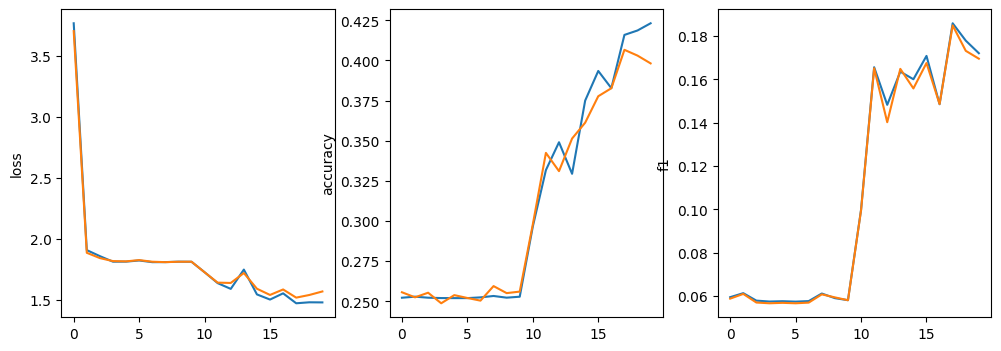

In [47]:
fig, axes = plt.subplots(1,3,figsize = (12,4))
# blue = train  orange = valid
sns.lineplot(x = list(range(0,EPOCHS)), y = train_perf_df['loss'], ax = axes[0])
sns.lineplot(x = list(range(0,EPOCHS)), y = train_perf_df['accuracy'], ax = axes[1])
sns.lineplot(x = list(range(0,EPOCHS)), y = train_perf_df['f1'], ax = axes[2])

sns.lineplot(x = list(range(0,EPOCHS)), y = valid_perf_df['loss'], ax = axes[0])
sns.lineplot(x = list(range(0,EPOCHS)), y = valid_perf_df['accuracy'], ax = axes[1])
sns.lineplot(x = list(range(0,EPOCHS)), y = valid_perf_df['f1'], ax = axes[2])

In [49]:
train_perf_df

,loss,accuracy,f1
0,3.765461,0.252244,0.059440
1,1.909849,0.252900,0.061290
2,1.860675,0.252260,0.057848
3,1.815338,0.252035,0.057424
4,1.815697,0.252000,0.057574
5,1.825145,0.252000,0.057383
6,1.811363,0.252463,0.057629
7,1.811758,0.253334,0.061127
8,1.815391,0.252279,0.058986
9,1.814612,0.252879,0.058052


In [50]:
torch.save(model.state_dict(), 'model_best_vloss.pth')